# Trabalho de Termodinâmica Aplicada: 
### Cálculos de propriedades termodinâmicas e de equilíbrio de fases utilizando equações de estado e modelos de G de excesso

#### Este trabalho é dividido em duas partes principais. Na primeira parte são feitos cálculos para os componentes puros ÁGUA e ETANOL, considerando a Equação de Estado SRK. Na segunda parte os cálculos são feitos para a mistura destes compostos, utilizando o modelo NRTL de G de excesso .

#### *PARTE 1*

### *A) Cálculo da pressão de saturação pela Equação de Estado Soave-Redlich-Kwong (SRK)*

Primeira Etapa: Importação das bibliotecas


In [1]:
import numpy as np

In [2]:
from scipy import optimize as opt

As propriedades conhecidas das substâncias são as propriedades críticas (Tc e Pc) e o fator acêntrico (representado por w).

Considere a Equação de Estado de SRK, conforme definição abaixo:

$P=\frac{RT}{\bar{V}-b}-\frac{a(T)}{{\bar{V}}({\bar{V}+b})}$  

Onde, os parâmetros "a" e "b" podem ser calculados por:

$a(T)=\frac {{0.42748} {alpha} {R^2} {Tc^2}}{Pc} $

$b=\frac{{0.08664} {R}{Tc}}{{Pc}}$

O cálculo de alpha depende do fator acêntrico, conforme pode ser visto a paritr das duas equações a seguir:

$m={(0.48+1.574{w}-0.176{w^2})}$

$alpha={[1+{m}{(1-Tr^{1/2})}]^2}$

Onde

$Tr=\frac {T}{Tc}$

In [3]:
# Dados iniciais - Propriedades Críticas da água e etanol
# Temperatura - Kelvin
# Pressão - Pa

# Constante de gás
R = 8.3144598 #J.mol^−1.K^−1

#Tc (K)
#Pc (Pa)

#Etanol - Propriedades das substâncias puras

Tc=513.9
Pc = 61.48*(10**5)
w = 0.645

#definindo constante b
b=0.08664*(R*Tc)/Pc



Uma vez definidas as constantes a serem trabalhadas, a seguir será realizado o cálculo da Pressão de Saturação da substância pura.
Inicialmente, para dado P e T, estamos interessado em calcular os volumes das fases líquida e gasosa. A equação de SRK é uma equação de terceira ordem. Consequentemente, a equação possui três raízes. A menor raiz representa a fase liquida e a maior representa a fase gasosa. A raiz intermediária é desprezada. 
Para SRK, a solução é feita a partir da resolução do polinômio de terceira ordem abaixo:

${P}{{\bar{V}}^3}-{(RT)}{{\bar{V}}^2}+{(a-Pb^2-RTb)}{\bar{V}}-ab=0$

Realizando o cálculo para uma pressão e temperatura definidas

In [4]:
#Cálculo dos volumes para as condições abaixo
T = 323 #K
P = 100000 #Pa

T=323
Tr=T/Tc
m=(0.48+1.574*w-0.176*w**2)
alpha=(1+(m*(1-Tr**0.5)))**2
a=0.42748*(alpha*R**2*Tc**2)/Pc

Primeiro, são definidas as constantes do polinômio

In [5]:
#declaração dos coeficientes da Raiz da EOS de SRK
c3 = P #coeficiente de v^3  
c2 = -(R*T) #coeficiente de v^2
c1 = (a-P*b**2-R*T*b)  #coeficiente de v^1  
c0 = -a*b  #coeficiente de v^0

Os volumes são obtidos a aprtir da definição das raízes da equação

In [6]:
#Para achar as raízes do polinômio, utiliza-se a biblioteca do numpy importada anteriormente
v=np.roots([c3,c2,c1,c0])
print(v)

[  2.61046073e-02   6.78796032e-04   7.23018283e-05]


Conforme dito anteriormente, colocando em ordem crescente as raízes calculadas, chega-se ao volume da fase líquida e o volume da fase gasosa

In [7]:
[v_Liq, v_intermediate, v_Vap] = np.sort(v)
print( "T",T,"K","","P",P,"Pa","","V_liq",v_Liq,"V_vap", v_Vap )

T 323 K  P 100000 Pa  V_liq 7.23018282889e-05 V_vap 0.0261046072939


### Energia livre de Gibbs Residual

A Energia Livre de Gibbs Residual pode ser expressa da seguinte forma: 

$${\bar{G}^{Res}}={{(RT)} {[Z-1-ln(Z-Beta)-qI]}}$$

Onde:

$Beta=\frac{bP} {RT}$    

$Z=\frac{PV}{RT}$  O cálculo de Z será realizado considerando os volumes do líquido ou de vapor, a depender da fase estudada

$q=\frac{alpha}{bRT}$          

$I={ln(\frac{Z+Beta}{Z})}$

> Smith, van Ness, Abbott, 2005, 7th-pt-BR, Ch. (6.2, 6.3)

In [8]:
Z_liq=P*v_Liq/(R*T)
Z_vap=P*v_Vap/(R*T)
beta=b*P/(R*T)
q=a/(b*R*T)
I_liq=np.log((Z_liq+beta)/Z_liq)
I_vap=np.log((Z_vap+beta)/Z_vap)
G_residual_liq=R*T*(Z_liq-1-np.log(Z_liq-beta)-q*I_liq)
G_residual_vap=R*T*(Z_vap-1-np.log(Z_vap-beta)-q*I_vap)

print(T, "K", P, "Pa", G_residual_liq, G_residual_vap)

323 K 100000 Pa -3391.34793942 -74.1403313609


Obs: A menor energia de Gibbs residual representa a fase mais estável na temperatura e pressão calculada

## Cálculo da Pressão de Saturação

Agora, a pressão de saturação é a pressão $ P $ que faz com que a diferença na energia residual de Gibbs entre o líquido de ensaio e a fase de vapor seja igual a zero a uma determinada temperatura. Não podemos explicitar $P$ como uma função da diferença na energia residual de Gibbs, então definimos uma função $ Residuo=abs(G_residual_liq - G_residual_vap) $ de $ P $
e vamos resolvê-lo numericamente, ou seja, tentar vários valores de $ P $ de acordo com uma metodologia de atualização e critérios de convergência.

Para automatizar essa tarefa, implementamos uma função chamada ** `def Psat (T,iguessP):` **, que calcula as raízes do volume, como antes, e avalia a diferença entre a energia residual de Gibbs em cada um desses estados.

In [9]:
def P_sat(T,iguess_P):
    
    
#funções de T
#Definição das condições de contorno para o cálculo da Pressão de Saturação
    
    Tr=T/Tc
    m=(0.48+1.574*w-0.176*w**2)
    alpha=(1+(m*(1-Tr**0.5)))**2
    a=0.42748*(alpha*R**2*Tc**2)/Pc
 

    Residuo=1
    TOL=1e-9
    MAX=1000
    i=0
    P=iguess_P
 

############################# funções de P #declaração dos coeficientes da Raiz da EOS de SRK

    while(Residuo>TOL and i<MAX):#Ges dependem de V q depende de P
 
        c3 = P #coeficiente de v^3  
        c2 = -(R*T) #coeficiente de v^2
        c1 = (a-P*b**2-R*T*b)  #coeficiente de v^1  
        c0 = -a*b  #coeficiente de v^0
        v=np.roots([c3,c2,c1,c0])#Para achar as raízes do polinômio, utiliza-se a biblioteca do numpy importada anteriormente
        [v_Liq, v_intermediate, v_Vap] = np.sort(v)
                        
        Z_liq=P*v_Liq/(R*T)
        Z_vap=P*v_Vap/(R*T)
        beta=b*P/(R*T)
        q=a/(b*R*T)
        I_liq=np.log((Z_liq+beta)/Z_liq)
        I_vap=np.log((Z_vap+beta)/Z_vap)
        G_residual_liq=R*T*(Z_liq-1-np.log(Z_liq-beta)-q*I_liq)
        G_residual_vap=R*T*(Z_vap-1-np.log(Z_vap-beta)-q*I_vap)
        Residuo=abs(G_residual_liq - G_residual_vap)
        phi_L=np.exp(G_residual_liq/(R*T))
        phi_V=np.exp(G_residual_vap/(R*T))
        P=P*(phi_L/phi_V)
        i=i+1      

    
    return P

Psat=P_sat(356.2,101325)   
print ("Psat=",Psat)


Psat= 121865.231228


Para montagem do gráfico são selecionados 100 pontos de temperatura, começando e 100 K e indo até a temperatura crítica da substância. Para temperatura é calculada a pressão de saturação de referência.

Particularmente, nesta etapa, observou-se uma mensagem ao final. O que acontece é que em T = 636, já está em 98,3% de Tc, a pressão da complexo. Iisso é uma propagação de cálculos desde o calculo de V (phi deu complexo, Gres deu complexo, V deu comlexo). O volume, então, deu complexo por 1 de dois motivos:

1. Não há mais raiz real -- o ponto crítico previsto pela equação de estado está ligeiramente abaixo dos valores esperados (Tc, Pc, usados para parametrizar a e b)
2. houve erro numérico no solver roots (note que em 636 K temos uma parte complexa de valor 4e-8, que é quase zero)
3. ou uma combinação dos dois fenomenos: aproximação numerica em 636 e 641; subprevisão do ponto crítico em 647 (teoricamente em cima do ponto critico ainda deveriamos conseguir convergir)

    # Isso é normal acontecer em uma implementação numérica
    
A princípio, os métodos numéricos que estão sendo empregados já desprezam a parte complexa.
Onde foi calculado Psat = 22054853.2794+5.44533447393j, o programa já está plotando como 22054853.2794

In [10]:
guessP=100
Taxis=np.linspace(100,Tc,100) 
Paxis=np.zeros(100) 
Paxis[0]=P_sat(Taxis[0],guessP)
for i in range(1,100): #
    Paxis[i]=P_sat(Taxis[i],Paxis[i-1])
    #print(Paxis[i])

C:\Users\cls4\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


### *Calculo da Pressão de Saturação utilizando a Equação de Antoine*

As informações para a utilização da Equação de Antoine foram obtidas em (http://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Mask=4&Type=ANTOINE&Plot=on)



A Equação é a seguinte:

log(P) = A − (B / (T + C))

onde P = pressão de vapor (bar)e T = temperatura (K)


A, B e C são parâmetros determinados a partir de dados experimentais, e são válidos para faixas de temperatura definidas (pressão em bar, temperatura em K).

|       Etanol        |    A     |     B     |     C     |
|---------------------|----------|-----------|-----------|
|  364.8 a 513.91 K   | 4.92531  | 1432.526  |  -61.819  |
|  292.77 a 366.63 K  | 5.24677  | 1598.673  |  -46.424  |
|  273 a 351.70 K     | 5.37229  | 1670.409  |  -40.191  |
|    **Água**         |          |           |           |
|  379 a 573 K        | 3.55959  | 643.748   | -198.043  |
|  344 a 373 K        | 5.08354  | 1663.125  |  -45.622  |
|  334 a 363 K        | 5.07680  | 1659.793  |  -45.854  |
|  304 a 333 K        | 5.20389  | 1733.926  |  -39.485  |
|  273 a 303 K        | 5.40221  | 1838.675  |  -31.737  |


Na literatura estão disponíveis algumas variações na forma da Equação de Antoine, utilizando ln ao inves de log, ou temperatura em oC e pressão em kPa, e deve-se tomar cuidado ao utilizar os parâmetros acima nas unidades corretas. 

In [11]:
def Pantoine(T): 
    if T<(273):
        return 0

    elif T<(351.70):
        A = 5.37229
        B = 1670.409
        C = -40.191
    
     
    elif T<(366.63):
        A = 5.24677
        B = 1598.673
        C = -46.424

    elif T<(513.91):
        A = 4.92531
        B = 1432.526
        C = -61.819
    
    else: 
        return 0
            
                   
    return 10**(A - B/(C+T))*100000 
    
    
    
Psat_ant=Pantoine(373.15)  
print("Psat_ant",Psat_ant)  


Psat_ant 210869.74504374317


### *Aquisição de dados experimentais*

In [12]:
# obtenção dos dados experimentais de pressão de vapor de água
table = np.loadtxt('Dados de Psat - etanol.txt', dtype='float', comments='#', delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
T_exp = table[:,0]
P_exp = table[:,1]

### Plotar gráfico (SRK, Antoine, Dados experimentais)

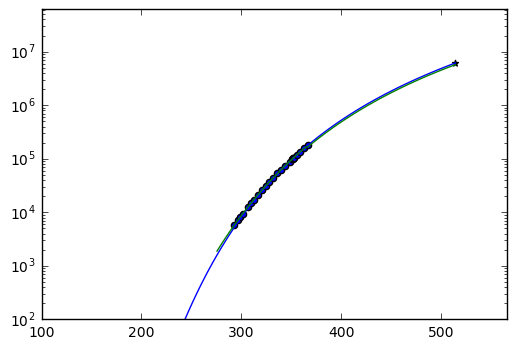

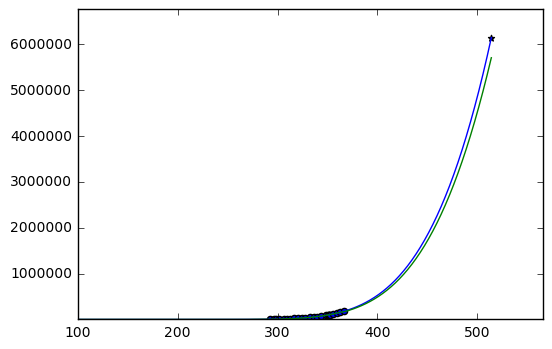

In [13]:
import matplotlib.pyplot as plt

#gerando matriz de dados com Pressão calculada por Antoine

Pantoineaxis = np.zeros(100) 
Pantoineaxis = [ Pantoine(Taxis[i]) for i in range(100) ] 

plt.figure(1)

plt.xlim([100,1.1*Tc]) #<- Definindo limites diferente para cada plot
plt.ylim([100,10*Pc])

plt.scatter(T_exp,P_exp)
plt.semilogy(Taxis,Paxis)
plt.semilogy(Taxis,Pantoineaxis)

plt.scatter(Tc,Pc,marker="*") #<- Ponto crítico foi marcado com um asterisco para ver se o gráfico chegou até lá com sucesso


plt.figure(2)

plt.xlim([100,1.1*Tc]) #<- Definindo limites diferente para cada plot
plt.ylim([100,1.1*Pc])

plt.scatter(T_exp,P_exp)
plt.plot(Taxis,Paxis)
plt.plot(Taxis,Pantoineaxis)

plt.scatter(Tc,Pc,marker="*") #<- Ponto crítico foi marcado com um asterisco para ver se o gráfico chegou até lá com sucesso
plt.show()

## Cálculo de Entalpia, Entropia e Volume Molar

Uma vez calculadas as condições de saturação (temperatura e pressão), o próximo objetivo do trabalho foi calcular a Entalpia e Entropia para o componente puro selecionado.

Para a equação de SRK, as seguintes equações foram encontradas para o cálculo da entalpia e entropia:

$\frac{H^{res}}{RT}= {(Z-1)}+ [\frac{dlnalpha(Tr)}{dlnTr}-1]{q}{I}$

Onde:
 

$Z=\frac{PV}{RT}$  O cálculo de Z será realizado considerando os volumes do líquido ou de vapor, a depender da fase estudada

$q=\frac{alpha}{bRT}$          

$I={ln(\frac{Z+Beta}{Z})}$

> Smith, van Ness, Abbott, 2005, 7th-pt-BR, Capítulo 6

Para SRK:

$\frac{dlnalpha(Tr)}{dlnTr}=-{m}(\frac{Tr}{alpha})^{0.5}$

A partir do valor calculado para G residual das fases líquida e vapor e dos valores de entalpia, a entropia é calculada conforme a relação abaixo:

${S^{res}}= \frac{Hre-Gres}{T}$





In [14]:
def HSFUNCIONALIZADO(T,P):
    
    Tr=T/Tc
    m=(0.48+1.574*w-0.176*w**2)
    alpha=(1+(m*(1-Tr**0.5)))**2
    a=0.42748*(alpha*R**2*Tc**2)/Pc
    
    #Calculando os volumes
    #declaração dos coeficientes da Raiz da EOS de SRK
    c3 = P  #coeficiente de v^3  
    c2 = -(R*T) #coeficiente de v^2
    c1 = (a-P*b**2-R*T*b)  #coeficiente de v^1  
    c0 = -a*b  #coeficiente de v^0
    v=np.roots([c3,c2,c1,c0])#Para achar as raízes do polinômio, utiliza-se a biblioteca do numpy importada anteriormente
    [v_Liq, v_intermediate, v_Vap] = np.sort(v)
    #print( "VL",v_Liq,"VV", v_Vap )

    Z_liq=P*v_Liq/(R*T)
    
    Z_vap=P*v_Vap/(R*T)
    
    
    
    ######ENTALPIA
    beta=b*P/(R*T)
    q=a/(b*R*T)
    I_liq=np.log((Z_liq+beta)/Z_liq)
    I_vap=np.log((Z_vap+beta)/Z_vap)
    der_Tr=-m*(Tr/alpha)**0.5
    
    
    Hres_liq=R*T*(Z_liq-1+(der_Tr-1)*q*I_liq)
    Hres_vap=R*T*((Z_vap-1)+(der_Tr-1)*q*I_vap)
    Res_H=abs(Hres_liq - Hres_vap)
    
    print("Hres_liq",Hres_liq)
    print("Hres_vap",Hres_vap)
    print("Res_H",Res_H, "J/mol",Res_H/18,"kJ/kg")
    
    
    
    ######ENTROPIA
    
    Gres_liq=R*T*(Z_liq-1-np.log(Z_liq-beta)-q*I_liq)
    Gres_vap=R*T*(Z_vap-1-np.log(Z_vap-beta)-q*I_vap)
    Res_G=abs(Gres_liq - Gres_vap)
    print("Res_G",Res_G)
    
    Sres_liq=(Hres_liq-Gres_liq)/T
    Sres_vap=(Hres_vap-Gres_vap)/T
    Res_S=abs(Sres_liq - Sres_vap)
    
    print("Sres_liq",Sres_liq)
    print("Sres_vap",Sres_vap)
    print("Res_S",Res_S, "J/mol",Res_S/18,"kJ/kg")
    
    #LOGO PODEMOS FAZER A SEGUINTE PROVA REAL: DELTAH-TDELTAS=0??
    Prova_real=Res_H-T*Res_S
    print("PROVA REAL: DELTAH-TDELTAS=0??",Prova_real)
    
    return Hres_liq, Hres_vap, Sres_liq, Sres_vap

#Teste 

teste = HSFUNCIONALIZADO(373.15,P_sat(373.15,1e5)) 


Hres_liq -38342.9503112
Hres_vap -408.285304208
Res_H 37934.665007 J/mol 2107.48138928 kJ/kg
Res_G 4.5758952183e-12
Sres_liq -102.422397466
Sres_vap -0.761764993393
Res_S 101.660632472 J/mol 5.64781291513 kJ/kg
PROVA REAL: DELTAH-TDELTAS=0?? -7.27595761418e-12


Hres_liq -63207.9170944
Hres_vap 0.0
Res_H 63207.9170944 J/mol 3511.55094969 kJ/kg
Res_G 1.18155580253e-11
Sres_liq -632.079170944
Sres_vap 0.0
Res_S 632.079170944 J/mol 35.1155094969 kJ/kg
PROVA REAL: DELTAH-TDELTAS=0?? -7.27595761418e-12
Hres_liq -62725.5262972
Hres_vap 0.0
Res_H 62725.5262972 J/mol 3484.75146095 kJ/kg
Res_G 6.15477191502e-12
Sres_liq -602.083315082
Sres_vap 0.0
Res_S 602.083315082 J/mol 33.4490730601 kJ/kg
PROVA REAL: DELTAH-TDELTAS=0?? 1.45519152284e-11
Hres_liq -62251.454509
Hres_vap 2.00055150543e-13
Res_H 62251.454509 J/mol 3458.41413939 kJ/kg
Res_G 2.22105834328e-29
Sres_liq -574.478830365
Sres_vap 1.84618094146e-15
Res_S 574.478830365 J/mol 31.9154905759 kJ/kg
PROVA REAL: DELTAH-TDELTAS=0?? 0.0
Hres_liq -61785.1703584
Hres_vap 0.0
Res_H 61785.1703584 J/mol 3432.50946436 kJ/kg
Res_G 6.64875771973e-12
Sres_liq -548.994486073
Sres_vap 0.0
Res_S 548.994486073 J/mol 30.4996936707 kJ/kg
PROVA REAL: DELTAH-TDELTAS=0?? 7.27595761418e-12
Hres_liq -61326.1900451
Hres_va

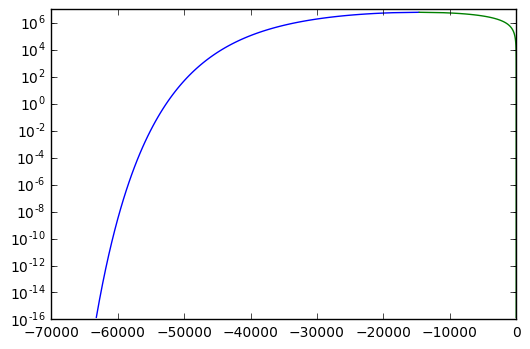

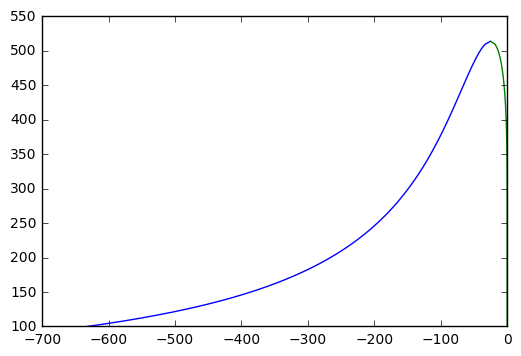

In [15]:
#Agrupando os resultados de entalpia e entropia

H_axis_l = np.zeros(100)
H_axis_v = np.zeros(100)
S_axis_l = np.zeros(100)
S_axis_v = np.zeros(100)

for i in range (0,100):
    H_axis_l[i], H_axis_v[i],S_axis_l[i], S_axis_v[i]=(HSFUNCIONALIZADO(Taxis[i],Paxis[i]))
    

plt.figure(1)
plt.semilogy(H_axis_l,Paxis)
plt.semilogy(H_axis_v,Paxis)

plt.figure(2)
plt.plot(S_axis_l,Taxis)
plt.plot(S_axis_v,Taxis)

plt.show()